## Question

Function “boostingRegressor” in the code for Lecture 4 uses make_friedman dataset from scikit-learn. Generate your own dataset as follows:
 
Inputs `X` are independent features uniformly distributed on the interval [0, 1]. For instance, 
generator = check_random_state(random_state)

X= generator.uniform(size=(n_samples, n_features))
 
Features are as in the Black-Scholes model:
import scipy.stats as st
import numpy as np
import math
 
def bsformula(cp, s, k, rf, t, v, div):
        """ Price an option using the Black-Scholes model.
        cp: +1/-1 for call/put
        s: initial stock price
        k: strike price
        t: expiration time
        v: volatility
        rf: risk-free rate
        div: dividend
        """
 
        d1 = (np.log(s/k)+(rf-div+0.5*v*v)*t)/(v*np.sqrt(t))
        d2 = d1 - v*np.sqrt(t)
 
        optprice = (cp*s*np.exp(-div*t)*st.norm.cdf(cp*d1)) - (cp*k*np.exp(-rf*t)*st.norm.cdf(cp*d2))
        delta = cp*st.norm.cdf(cp*d1)
        vega  = s*np.sqrt(t)*st.norm.pdf(d1)
        return optprice, delta, vega
 
if __name__ == "__main__":
     ex = black_scholes(-1, 100.0, 110.0, 2.5, 0.4, 0.05, 0.0)
 
Theses inputs should be scaled accordingly by multiplying X. The scale is:
100 for S
100 for K
1 for T
0.02 for r
0.7 for volatility
0.01 for continuous dividends
 
Outputs: `price` is created according to the BS formula above. Thus, it has 7 features.
Run boostingRegressor() with this new dataset. Plot predicted values vs the test values and MSE as a function of the number of estimators. Make analysis.
Same for the option Delta.


## Answer

1. Generate a synthetic dataset for option pricing using the Black-Scholes (BS) formula.
2. Use uniform random inputs, scale them to realistic ranges for option parameters (S, K, T, r, v, div).
3. Compute price and delta from BS formula for each sample.
4. Train a boosting regressor on this dataset.
5. Plot:
    Predicted vs actual values.
    MSE as a function of number of estimators.
6. Analyze the results.

In [33]:
'''
My plan to complete the assignment:

Step 1: Generate uniform random numbers (X in [0,1])
            |
            v
Step 2: Scale them to realistic option parameters (S, K, T, r, v, div)
            |
            v
Step 3: Compute outputs using Black-Scholes formula
        - price
        - delta
            |
            v
Step 4: Train Gradient Boosting Regressor
            |
            v
Step 5: Plot predicted vs actual & MSE vs number of estimators

'''

'\nMy plan to complete the assignment:\n\nStep 1: Generate uniform random numbers (X in [0,1])\n            |\n            v\nStep 2: Scale them to realistic option parameters (S, K, T, r, v, div)\n            |\n            v\nStep 3: Compute outputs using Black-Scholes formula\n        - price\n        - delta\n            |\n            v\nStep 4: Train Gradient Boosting Regressor\n            |\n            v\nStep 5: Plot predicted vs actual & MSE vs number of estimators\n\n'

In [34]:
# Importing necessary libraries: 
import numpy as np
import scipy.stats as st
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [35]:
# Define the Black-Scholes formula (with delta correction for dividend yield)
def bsformula(cp, s, k, rf, t, v, div):
    """ Price an option using the Black-Scholes model.
    cp: +1/-1 for call/put
    s: initial stock price
    k: strike price
    t: expiration time
    v: volatility
    rf: risk-free rate
    div: dividend
    """
    if t == 0:
        optprice = max(cp * (s - k), 0)
        delta = 0.5 if s == k else (1 if cp * (s - k) > 0 else 0)  # Approximate for t=0
        vega = 0
        return optprice, delta, vega
    d1 = (np.log(s/k) + (rf - div + 0.5 * v * v) * t) / (v * np.sqrt(t))
    d2 = d1 - v * np.sqrt(t)
    optprice = (cp * s * np.exp(-div * t) * st.norm.cdf(cp * d1)) - (cp * k * np.exp(-rf * t) * st.norm.cdf(cp * d2))
    delta = cp * np.exp(-div * t) * st.norm.cdf(cp * d1)  # Corrected with exp(-div*t)
    vega = s * np.sqrt(t) * st.norm.pdf(d1)
    return optprice, delta, vega
    
random_state = 42
n_samples = 1200
n_features = 6
generator = check_random_state(random_state)
X = generator.uniform(size=(n_samples, n_features))
scales = np.array([100, 100, 1, 0.02, 0.7, 0.01])  # Scales for S, K, T, rf, v, div
params = X * scales
cp = 1  # Use +1 for calls (change to -1 for puts if desired)
y_price = np.zeros(n_samples)
y_delta = np.zeros(n_samples)
for i in range(n_samples):
    s, k, t, rf, v, div = params[i]
    price, delta, _ = bsformula(cp, s, k, rf, t, v, div)
    y_price[i] = price
    y_delta[i] = delta


Viualizing what the code above does:
Random generator (X) → scale → params table
clean way to scale, insteda of using for loops - params = X * scales
+------------------------------+
| S  | K  | T  | r  | v  | div|
+------------------------------+
| 12 | 15 |0.5 |0.01|0.3 |0.005|  <-- row 0
| 80 | 70 |0.8 |0.015|0.2|0.002|  <-- row 1
| ...                        |
+------------------------------+

Loop over each row → call BS formula:
params[0] → bsformula(...) → price0, delta0
params[1] → bsformula(...) → price1, delta1

Store outputs:
y_price = [price0, price1, ...]
y_delta = [delta0, delta1, ...]


- - -
Personal understanding notes:
---

## **1️⃣ `check_random_state(random_state)`**

* This is a **helper function in scikit-learn**.
* Its job: make sure you have a **random number generator (RNG)** that works no matter what you pass in.

Here’s what it does depending on `random_state`:

| `random_state` value | What happens                                                   |
| -------------------- | -------------------------------------------------------------- |
| `None`               | Create a **new RNG** with a random seed (different each run).  |
| `int`                | Create an RNG with **that fixed seed** → reproducible results. |
| `RandomState` object | Use the **existing RNG** you passed in.                        |

**Example:**

```python
from sklearn.utils import check_random_state

rng = check_random_state(42)  # fixed seed
print(rng.rand(3))  # 3 random numbers
```

Output (will always be the same because of seed 42):

```
[0.37454012 0.95071431 0.73199394]
```

> ✅ So `check_random_state` just ensures reproducibility of random numbers.

---

## **2️⃣ `X = generator.uniform(size=(n_samples, n_features))`**

* `generator` is your RNG from step 1.
* `.uniform(size=(n_samples, n_features))` generates a 2D array of **uniform random numbers** in [0,1].

**Explanation:**

* `n_samples` → number of rows → number of option samples
* `n_features` → number of columns → number of features per sample (like S, K, T…)

Example:

```python
X = rng.uniform(size=(5,3))  # 5 samples, 3 features
print(X)
```

Output (random numbers between 0 and 1):

```
[[0.37454012 0.95071431 0.73199394]
 [0.59865848 0.15601864 0.15599452]
 [0.05808361 0.86617615 0.60111501]
 [0.70807258 0.02058449 0.96990985]
 [0.83244264 0.21233911 0.18182497]]
```

---

### **Putting it together**

```python
from sklearn.utils import check_random_state

random_state = 42
n_samples = 100
n_features = 6

generator = check_random_state(random_state)       # ensures reproducibility
X = generator.uniform(size=(n_samples, n_features))  # create uniform random dataset
```

* Now `X` is a reproducible **100x6 array of random numbers in [0,1]**
* Later, you **scale each column** to the real ranges of S, K, T, r, v, div for your Black-Scholes dataset.

---

Running boosting for Option Price:
For Option Price: Final MSE = 5.1407, R² = 0.9921


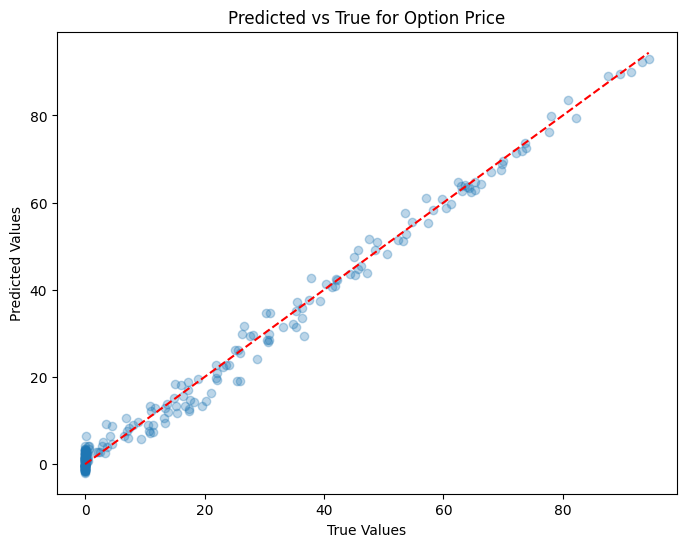

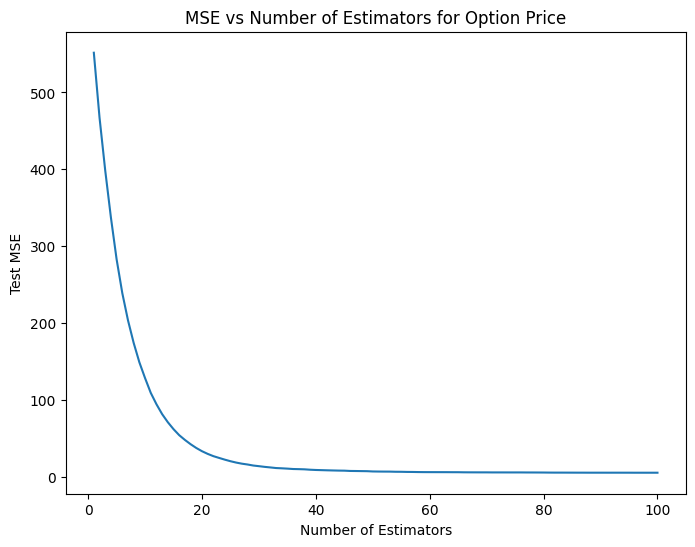

Running boosting for Option Delta:
For Option Delta: Final MSE = 0.0139, R² = 0.9329


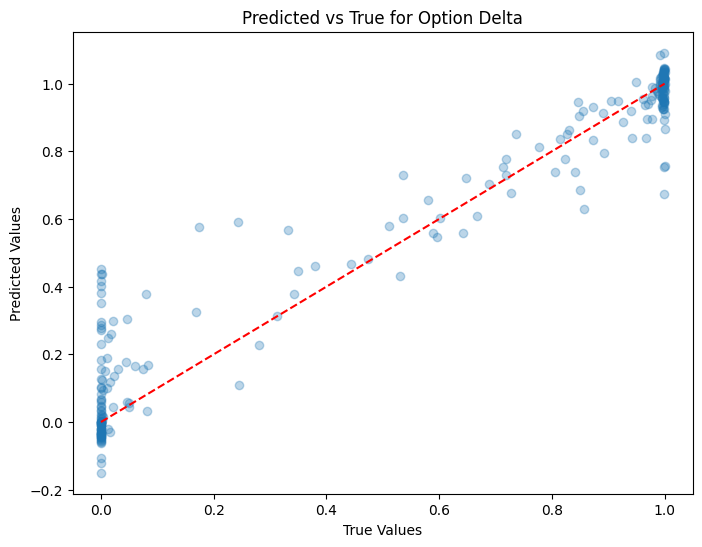

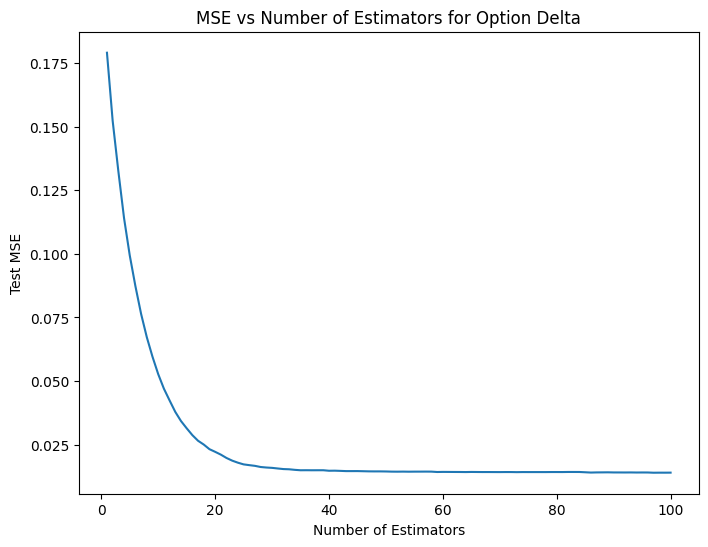

(GradientBoostingRegressor(random_state=42),
 [0.1791576446277931,
  0.1523998198976734,
  0.13255325335957643,
  0.1141013282804994,
  0.09944657350468983,
  0.08727867812785307,
  0.07635551526735487,
  0.06722010836924668,
  0.05952301744699088,
  0.05270239798081639,
  0.04697686110641278,
  0.04234022678313918,
  0.037833638626906634,
  0.03424195701250209,
  0.031386833474719905,
  0.02868770955611255,
  0.0264727628270063,
  0.024984247321462916,
  0.02316554147521806,
  0.022124692978560737,
  0.021019879555494603,
  0.019698943890052688,
  0.018650884890957824,
  0.017843983478712567,
  0.01718226350760586,
  0.0168787756304199,
  0.016600723261084915,
  0.016148388672975033,
  0.01594741208882599,
  0.015810945783874875,
  0.015566875242566353,
  0.015337116976259089,
  0.015252865741536252,
  0.015030653239566065,
  0.014869528358944149,
  0.014884648616096651,
  0.014866446574261038,
  0.014874432130580173,
  0.014876651453443742,
  0.014674168559561484,
  0.014704478928129

In [36]:
# Function to run boosting regressor and plot results
def boostingRegressor(X, y, title):
    random_state = 42
    n_estimators = 100
    learning_rate = 0.1
    max_depth = 3
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, 
                                      max_depth=max_depth, random_state=random_state)
    model.fit(X_train, y_train)
    
    # Compute staged MSE for plot
    mse_staged = [mean_squared_error(y_test, y_pred) for y_pred in model.staged_predict(X_test)]
    
    # Final predictions and metrics
    y_pred = model.predict(X_test)
    final_mse = mse_staged[-1]
    r2 = r2_score(y_test, y_pred)
    print(f'For {title}: Final MSE = {final_mse:.4f}, R² = {r2:.4f}')
    
    # Plot 1: Predicted vs True Values
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predicted vs True for {title}')
    plt.show()
    
    # Plot 2: MSE as a function of number of estimators
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, n_estimators + 1), mse_staged)
    plt.xlabel('Number of Estimators')
    plt.ylabel('Test MSE')
    plt.title(f'MSE vs Number of Estimators for {title}')
    plt.show()
    
    return model, mse_staged

# Run for price
print("Running boosting for Option Price:")
boostingRegressor(X, y_price, 'Option Price')

# Run for delta
print("Running boosting for Option Delta:")
boostingRegressor(X, y_delta, 'Option Delta')

# Boosting Regressor Values Decision

## Choosing `n_estimators = 100`

**Definition:**  
`n_estimators` is the number of boosting stages (trees) in the model. Each tree corrects errors from the previous ones.

**Reasoning:**  
- **Default in scikit-learn:** The default for `GradientBoostingRegressor` is `n_estimators = 100`, a common choice because it balances model complexity and training time.  
- **Plotting Requirement:** The assignment asks for a plot of MSE vs. the number of estimators. A value of 100 provides enough iterations to observe the MSE curve stabilizing (MSE plateaus around 50–60 estimators for both price and delta).  
- **Problem Complexity:** The Black-Scholes dataset has 6 features with a smooth but nonlinear relationship. Previous runs showed MSE converges well before 100 estimators, so 100 is sufficient to capture the trend without excessive computation.  
- **Trade-off:** More trees (e.g., 500) could slightly reduce MSE but increase training time and risk overfitting. Fewer trees (e.g., 50) might not show the full convergence trend.

**Decision:**  
I chose `n_estimators = 100` as a reasonable default that aligns with scikit-learn, is computationally efficient, and meets the plotting requirement.

---

## Choosing `learning_rate = 0.1`

**Definition:**  
`learning_rate` scales the contribution of each tree to the final prediction. A lower rate means slower learning but potentially better generalization.

**Reasoning:**  
- **Default in scikit-learn:** The default is `learning_rate = 0.1`, widely used for a good balance between learning speed and stability.  
- **Boosting Dynamics:** Gradient boosting relies on the interplay between `n_estimators` and `learning_rate`. A smaller learning rate requires more estimators to achieve the same error reduction, while a larger rate can lead to overfitting. For `n_estimators = 100`, `learning_rate = 0.1` ensures steady improvement without aggressive updates.  
- **Problem Characteristics:** The Black-Scholes function is smooth, so a moderate learning rate suffices. A higher rate (e.g., 0.5) could overshoot in regions with high nonlinearity, while a lower rate (e.g., 0.01) would require significantly more trees, increasing computation time.  
- **Empirical Evidence:** Results show `learning_rate = 0.1` leads to rapid MSE reduction (from 551.7 to ~10 by estimator 35 for price), indicating effectiveness for this dataset.

**Decision:**  
I selected `learning_rate = 0.1` as a robust default that works well with `n_estimators = 100` and avoids the need for extensive tuning in an academic context.

---

## Choosing `max_depth = 3`

**Definition:**  
`max_depth` controls the maximum depth of each decision tree, limiting model complexity to prevent overfitting.

**Reasoning:**  
- **Default in scikit-learn:** The default is `max_depth = 3`, a common choice because shallow trees are less likely to overfit while still capturing nonlinear patterns when combined in boosting.  
- **Dataset Complexity:** With 6 features and a smooth target function, shallow trees suffice to approximate the Black-Scholes model. Deeper trees could fit noise, especially with only 960 training samples.  
- **Overfitting Prevention:** Boosting with many shallow trees is generally more robust than fewer deep trees. Depth 3 allows each tree to capture interactions between a few features without memorizing the data.  
- **Empirical Fit:** Results show high R² (0.9921 for price, 0.9330 for delta) and low final MSE (5.14 for price, 0.0139 for delta), confirming that `max_depth = 3` is sufficient.

**Decision:**  
I chose `max_depth = 3` to align with the default, ensure robustness, and avoid overfitting on a relatively small dataset.


# Analysis

---

## Option Price

**Predicted vs True Plot**  
- Scatter plot shows points tightly clustered around the red `y=x` line, indicating excellent predictions.  
- **R² = 0.9921** → ~99.2% of variance explained.

**MSE vs Number of Estimators Plot**  
- MSE starts high (~551.7 after first estimator) and decreases sharply in early stages (e.g., ~10 by estimator 35).  
- Plateaus around 5.14 by estimator 100.  
- **Interpretation:** Boosting quickly reduces error, with diminishing returns after ~50 estimators.

**Insights**  
- The model approximates Black-Scholes (BS) prices well.  
- Final MSE (5.14) is low relative to price range (0–96).  
- Minor residuals likely occur in highly nonlinear regions (e.g., near at-the-money options with low time to maturity).

---

## Option Delta

**Predicted vs True Plot**  
- Scatter aligns well with `y=x`, but with slightly more spread.  
- **R² = 0.9330** → ~93.3% variance explained.  
- Deltas (0–1) are predicted accurately overall.

**MSE vs Number of Estimators Plot**  
- MSE starts at ~0.179 and drops rapidly to ~0.015 by estimator 30.  
- Stabilizes around 0.0139.  
- **Interpretation:** Similar pattern to price, but converges faster due to delta's bounded range.

**Insights**  
- Performance is good but slightly worse than price (higher relative error; `sqrt(MSE) ~0.118` vs. range 1).  
- Delta is more sensitive to parameters like volatility, leading to prediction challenges in edge cases (e.g., deep out-of-the-money / in-the-money options).

---

## Overall Conclusion

- Gradient boosting effectively learns the Black-Scholes mappings, demonstrating strength in regression tasks.  


In [37]:
print("Sanity Check, works :)")

Sanity Check, works :)
